In [6]:
from abc import ABC,abstractmethod
import json
from datetime import datetime, timedelta
import sys
from random import randint
import numpy as np
from numpy.random import exponential

In [199]:
class typeGenerator(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def generateEl(self,**args):
        pass

    def addDict(self,d,keyName,**args):
        d[keyName] = self.generateEl(**args)
        return d

class intGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        min = args.get("min",0)
        max = args.get("max",1000)
        return randint(min, max)

class idGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        prefix = args.get("prefix","id")
        min = args.get("min",0)
        max = args.get("max",1000)
        return prefix+"_"+str(randint(min, max)).zfill(len(str(max))+1)

    def addDict(self, d,keyName="id", **args):
        return super().addDict(d, keyName,**args)

class dateGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        startDate = args.get("startDate",datetime(2010,1,1))
        endDate = args.get("endDate",datetime.now())
        minPaceSeconds = args.get("minPaceSeconds",3600)
        maxPaceSeconds = args.get("maxPaceSeconds",datetime.now())
        maxS = int((endDate-startDate).total_seconds())
        return startDate+timedelta(0,randint(minPaceSeconds,maxS))

    def addDict(self, d, keyName="ts", **args):
        return super().addDict(d, keyName,**args)

class tickGenerator(typeGenerator):
    def __init__(self):
        self.lastTick = False
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        if not self.lastTick:
            self.lastTick = args.get("firstTick",datetime(2010,1,1))
        minTick = args.get("minTick",1)
        maxTick = args.get("maxTick",10)
        self.lastTick += timedelta(0,randint(1,maxTick))
        return self.lastTick

In [200]:
class expIntGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        scale = args.get("scale",1)
        multiplier = args.get("multiplier",500)
        return round(exponential(scale) * multiplier)

In [201]:
class expFloatGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        scale = args.get("scale",1)
        multiplier = args.get("multiplier",500)
        return (exponential(scale) * multiplier)

In [10]:
import matplotlib.pyplot as plt

In [11]:
x = expIntGenerator()

to_plot = ([(x.generateEl()) for _ in range(10000)])

(array([5.572e+03, 2.520e+03, 1.080e+03, 4.630e+02, 2.110e+02, 9.000e+01,
        3.500e+01, 1.600e+01, 1.000e+01, 3.000e+00]),
 array([   0. ,  414.6,  829.2, 1243.8, 1658.4, 2073. , 2487.6, 2902.2,
        3316.8, 3731.4, 4146. ]),
 <a list of 10 Patch objects>)

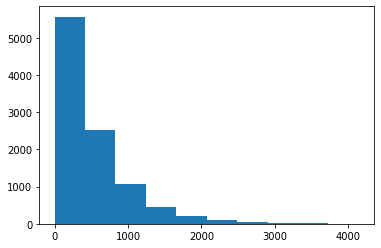

In [12]:
plt.hist(to_plot)

In [13]:
x = expFloatGenerator()

to_plot = ([(x.generateEl()) for _ in range(10000)])

(array([6.725e+03, 2.167e+03, 7.370e+02, 2.470e+02, 8.700e+01, 2.400e+01,
        9.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([1.61078161e-02, 5.50004734e+02, 1.09999336e+03, 1.64998199e+03,
        2.19997061e+03, 2.74995924e+03, 3.29994787e+03, 3.84993649e+03,
        4.39992512e+03, 4.94991375e+03, 5.49990237e+03]),
 <a list of 10 Patch objects>)

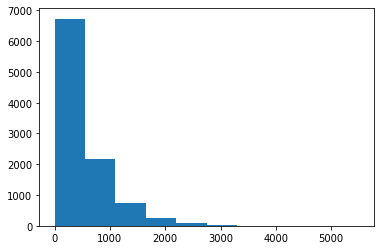

In [14]:
plt.hist(to_plot)

In [202]:
class nonUniformeIdGenerator(typeGenerator):
    def __init__(self):
        return super().__init__()

    def generateEl(self,*argList,**args):
        if argList:
            args = argList[0]
        prefix = args.get("prefix","id")
        lam = args.get("lam",1)
        multiplier = args.get("multiplier",1)
        #return prefix+"_"+str(np.random.poisson(lam=1.0)*multiplier).zfill(len(str(max))+1)
        return f"{prefix}_{round(np.random.poisson(lam)*multiplier)}"

    def addDict(self, d,keyName="id", **args):
        return super().addDict(d, keyName,**args)

In [203]:
x = nonUniformeIdGenerator()

to_plot = ([(x.generateEl(lam=10)) for _ in range(10000)])

(array([2081., 1709., 1847., 2647., 1094.,  188.,  265.,   88.,   56.,
          25.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

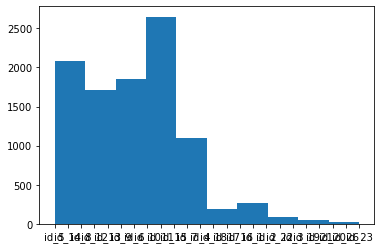

In [36]:
plt.hist(to_plot)

# Challenge implementation

## Registry dataset generator

Generate a registry dataset with unique keys

In [209]:
import math
import random 
import itertools

class registryDatasetGenerator(object):
    def __init__(self):
        self.generators = []
        # added difference between data and keys generator
        self.keys_generators = []
        # added keyset to not allow duplicates in generation
        self.keys_set = set()

    def addGenerator(self,typeGenerator,keyName=False,keyAttr=False,**args):
        gen = {"generator":typeGenerator,"keyName":keyName,"args":args}
        if keyAttr:
            self.keys_generators.append(gen)
        else:
            self.generators.append(gen)

    def removeGenerator(self,keyName):
        self.generators = [gen for gen in self.generators if gen.get("keyName") != keyName]

    def generateKey(self):
        # keys generation now does not produce duplicates
        found = False
        t = {}
        while(not found):
            t = {gen.get("keyName") : gen.get("generator").generateEl() for gen in self.keys_generators}
            v = tuple(t.values())
            found = v not in self.keys_set
            if found:
                self.keys_set.add(v)
        return t

    def generateRow(self):
        # generate row not iters over normal generators
        row = {}
        for gen in self.generators:
            if not gen.get("keyName"):
                gen.get("generator").addDict(row,**gen.get("args"))
            else:
                gen.get("generator").addDict(row,gen.get("keyName"),**gen.get("args"))
        return row

    def generateDataset(self,numRows):
        # generate keys, and then add data
        return [{**self.generateKey(),**self.generateRow()} for k in range(numRows)] 

## Registry CDC dataset generator

Generate updates to the original dataset using a certain percentage of old keys, and new keys

In [210]:
class registryCdcDatasetGenerator(registryDatasetGenerator):
    def __init__(self, dataset):
        super()
        # needed for generating a new 'part' of dataset
        self.or_dataset = dataset

    def generateRegistryCdcDataset(self,numRows,updates_perc=0.5):
        # generate registry first computes the number of updates to be generated
        # then uses the keys set to find keys to update
        # it then uses the old dataset generator to generate new tuples
        num_old = min(len(self.or_dataset.keys_set), math.floor(numRows*updates_perc))
        ret = []
        for e in set(random.sample(self.or_dataset.keys_set, num_old)) :
            t = {gen.get("keyName") : e[i] for i, gen in enumerate(self.or_dataset.keys_generators)}
            t.update(self.or_dataset.generateRow())
            ret.append(t)
        return ret + self.or_dataset.generateDataset(numRows-num_old)

## Log dataset generator

Log dataset generator, no costraints whatsoever

In [211]:
class logDatasetGenerator(object):
    def __init__(self):
        self.generators = []

    def addGenerator(self,typeGenerator,keyName=False,keyAttr=False,**args):
        gen = {"generator":typeGenerator,"keyName":keyName,"args":args}
        self.generators.append(gen)

    def removeGenerator(self,keyName):
        self.generators = [gen for gen in self.generators if gen.get("keyName") != keyName]

    def generateRow(self):
        # generate row not iters over normal generators
        row = {}
        for gen in self.generators:
            if not gen.get("keyName"):
                gen.get("generator").addDict(row,**gen.get("args"))
            else:
                gen.get("generator").addDict(row,gen.get("keyName"),**gen.get("args"))
        return row

    def generateDataset(self,numRows):
        # generate keys, and then add data
        return [self.generateRow() for k in range(numRows)]

In [212]:
dataset = registryDatasetGenerator()
dataset.addGenerator(idGenerator(),prefix="user",keyName="userId", keyAttr=True)
dataset.addGenerator(idGenerator(),prefix="item",keyName="itemId", keyAttr=True)
dataset.addGenerator(tickGenerator(),keyName="ts")
dataset.addGenerator(intGenerator(),keyName="qty")
dataset.addGenerator(expIntGenerator(),"vol")
dataset.addGenerator(intGenerator(),"cost")
dataset.generateDataset(10)

[{'userId': 'id_00147',
  'itemId': 'id_00120',
  'ts': datetime.datetime(2010, 1, 1, 0, 0, 6),
  'qty': 67,
  'vol': 104,
  'cost': 686},
 {'userId': 'id_00555',
  'itemId': 'id_00108',
  'ts': datetime.datetime(2010, 1, 1, 0, 0, 14),
  'qty': 214,
  'vol': 1133,
  'cost': 646},
 {'userId': 'id_00663',
  'itemId': 'id_00214',
  'ts': datetime.datetime(2010, 1, 1, 0, 0, 24),
  'qty': 837,
  'vol': 31,
  'cost': 654},
 {'userId': 'id_00028',
  'itemId': 'id_00310',
  'ts': datetime.datetime(2010, 1, 1, 0, 0, 33),
  'qty': 890,
  'vol': 343,
  'cost': 345},
 {'userId': 'id_00995',
  'itemId': 'id_00586',
  'ts': datetime.datetime(2010, 1, 1, 0, 0, 41),
  'qty': 512,
  'vol': 352,
  'cost': 887},
 {'userId': 'id_00892',
  'itemId': 'id_00565',
  'ts': datetime.datetime(2010, 1, 1, 0, 0, 44),
  'qty': 631,
  'vol': 933,
  'cost': 646},
 {'userId': 'id_00013',
  'itemId': 'id_00946',
  'ts': datetime.datetime(2010, 1, 1, 0, 0, 50),
  'qty': 115,
  'vol': 265,
  'cost': 399},
 {'userId': 'id

Generating an update for the dataset, consisting in 4 rows and a percentage of old rows of 0.6

In [213]:
cdcgen = registryCdcDatasetGenerator(dataset)
cdcgen.generateRegistryCdcDataset(20, 0.6)

[{'userId': 'id_00523',
  'itemId': 'id_00690',
  'ts': datetime.datetime(2010, 1, 1, 0, 1, 4),
  'qty': 703,
  'vol': 33,
  'cost': 677},
 {'userId': 'id_00028',
  'itemId': 'id_00310',
  'ts': datetime.datetime(2010, 1, 1, 0, 1, 8),
  'qty': 940,
  'vol': 355,
  'cost': 662},
 {'userId': 'id_00147',
  'itemId': 'id_00120',
  'ts': datetime.datetime(2010, 1, 1, 0, 1, 9),
  'qty': 814,
  'vol': 632,
  'cost': 328},
 {'userId': 'id_00013',
  'itemId': 'id_00946',
  'ts': datetime.datetime(2010, 1, 1, 0, 1, 16),
  'qty': 803,
  'vol': 7,
  'cost': 800},
 {'userId': 'id_00737',
  'itemId': 'id_00442',
  'ts': datetime.datetime(2010, 1, 1, 0, 1, 19),
  'qty': 87,
  'vol': 288,
  'cost': 97},
 {'userId': 'id_00995',
  'itemId': 'id_00586',
  'ts': datetime.datetime(2010, 1, 1, 0, 1, 29),
  'qty': 1,
  'vol': 1638,
  'cost': 264},
 {'userId': 'id_00555',
  'itemId': 'id_00108',
  'ts': datetime.datetime(2010, 1, 1, 0, 1, 38),
  'qty': 226,
  'vol': 99,
  'cost': 358},
 {'userId': 'id_00663',